In [78]:
#import necessary libraries
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_svmlight_file

In [92]:
def subgradloss(x, y, w):
    xT = np.transpose(x) # change to col vector
    d  = np.size(w1)-1
    w  = w1[0:d]
    b  = w1[d]
    tmp = 1-y*(w@x.T+b) # choose subgrad of max(t,0) at 0 to be 1/2
    tmp = (np.sign(tmp)+1)/2
    tmp2 = np.concatenate((x,[1]))
    tmp2 = -y*tmp2
    tmp2 = tmp*tmp2
    return tmp2   # a row vector

In [93]:
def subgradreg(regparam, w): # w=w1[0:d]
    return regparam * np.concatenate((w,[0])) 

In [126]:
def sgdmethod(X, y, subgradloss, subgradreg, regparam, w1, T, a, m):
    d=np.size(w1)-1 # w1 is initial guess. m=1: SGD. m=n: sub-GD.
    w=w1[0:d]
    b=w1[d] 
    n=np.size(X[:,0])
    w_hist=np.zeros((d+1,T)) # store all iterates (w1) for ite in np.arange(T):
    w_avg=np.zeros((d+1,T))
    for itr in np.arange(T):
        index = np.random.choice(n,m,replace=False) # sample minibatch without replacement
        batchloss_sum=np.zeros(d+1)
        for i in index:
            xi=X[i]
            yi=y[i]
            loss=subgradloss(xi,yi,w1) 
            batchloss_sum+=loss
        batchloss_avg = batchloss_sum/m
        grad = batchloss_avg+subgradreg(regparam,w)
        alpha=1/(1+a*itr)
        w1=w1-alpha*grad
        w_hist[:,itr]=w1
    for itr in np.arange(T):
        w_avg[:,itr]=np.mean(w_hist[:,:itr//2])
    return w_hist,w_avg

    

In [127]:
def obj(X,y,w1,regparam): #helper function for checking f(x)
    n=np.size(X[:,0]) # 32561
    ob=0
    d=np.size(w1)-1 # 122
    w=w1[0:d] 
    b=w1[d] 
    for i in np.arange(n):
        xT=np.transpose(X[i]) 
        tmp=1-y[i]*(w@xT+b) 
        temp=np.maximum(tmp,0) 
        ob=ob+tmp
        ob=ob/n
        ob=ob+regparam/2*np.square(LA.norm(w))
        return ob

In [128]:
def get_data(n):
    data = load_svmlight_file(n)
    return data[0].toarray(), data[1].reshape((data[1].shape[0], 1))


X_train, y_train = get_data("a9a")
X_test, y_test = get_data("a9a.t")
X_train = np.delete(X_train, -1, 1)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

n = np.size(X_train[:,0]) # 32561
d = np.size(X_train[0])
regparam = 1/n # lambda
w1 = np.zeros(d+1) # init (w,b)

m = 32561
T = (32561//m)*100
a = 0.01
 
w_hist, w_avg=sgdmethod(X_train, y_train, subgradloss, subgradreg, regparam, w1, T, a, m)


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'objective')

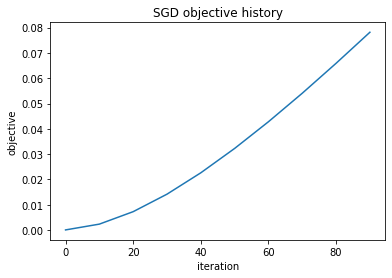

In [129]:
## objective:

num = 10
ite_hist = np.zeros(num) 
obj_hist = np.zeros(num) 
temp = 0 
dist = T/num # distance between 50 equally spaced points 

for i in np.arange(T): # try plot obj if i % dist == 0:
    if i % dist == 0:
        ite_hist[temp]=i
        obj_hist[temp] = obj(X_train,y_train,w_hist[:,i],regparam)
        temp+=1
plt.plot(ite_hist, obj_hist) 
plt.title('SGD objective history') 
plt.xlabel('iteration') 
plt.ylabel('objective')

No handles with labels found to put in legend.


Text(0, 0.5, 'accuracy')

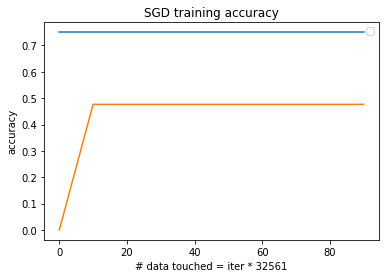

In [130]:
## training accuracy:
num = 10
train_accu_hist = np.zeros(num)
train_accu_hist_avg = np.zeros(num) 
for t in np.arange(0,T,T/num).astype(int):# assume T is multiple of ’num’. Set to integer.
    w1 = w_hist[:,t] 
    w2 = w_avg[:,t]
    w = w1[:d]
    b = w1[d]
    ww = w2[:d]
    bb = w2[d]
    train_correct = 0
    train_correct_avg = 0 
    for i in np.arange(n):
        z = w@X_train[i]+b
        zz = ww@X_train[i]+bb
        if y_train[i]*z > 0:
            train_correct+=1
        if y_train[i]*zz > 0:
            train_correct_avg+=1
    train_accu = train_correct/n
    train_accu_hist[np.int(t/(T/num))] = train_accu
    
    train_accu_avg = train_correct_avg/n
    train_accu_hist_avg[np.int(t/(T/num))] = train_accu_avg
    
# print('Training Accuracy:')
plt.plot(ite_hist, train_accu_hist) ## SGD 
plt.plot(ite_hist, train_accu_hist_avg) ## SGD 
# plt.legend()
plt.title('SGD training accuracy') 
plt.xlabel('# data touched = iter * 32561')  # = iter for SGD, = iter * 32561 for GD 
plt.ylabel('accuracy') 


In [105]:
## Testing accuracy:
n = np.size(X_test[:,0]) 
d = np.size(X_test[0])
k=20 # only care every k iter here.
num = np.int(T/k) # can’t use num = T for SGD, will take forever..
test_accu_hist = np.zeros(num)
for t in np.arange(0,T,T/num).astype(int):
    w1 = 1/(t/2+1)*np.sum(w_hist[:,np.int(t/2):t], axis=1)
    w = w1[:d]
    b = w1[d]
    test_correct = 0
    for i in np.arange(n):
        z = w@X_test[i]+b
        if y_test[i]*z > 0:
            test_correct+=1
    test_accu = test_correct/n
    test_accu_hist[np.int(t/(T/num))] = test_accu

print('Highest Test Accuracy:') 
print(np.max(test_accu_hist)) 
print('Highest Test Accuracy index:') 
print(np.argmax(test_accu_hist)*k)

Highest Test Accuracy:
0.7525336281555187
Highest Test Accuracy index:
20
